#### Test RS knn with cosine distance on mean centered data, evaluating with RSME and MAE

In [1]:
import numpy as np
import pandas as pd
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
import seaborn as sns
from reco_systems.evaluation import *
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/franciline/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/franciline/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/franciline/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/fr

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



In [2]:
# import DB et set min_reviews
folder = "database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"trictrac_database/users.csv", names=["Username", "User id"])

min_reviews = 5

In [3]:
# filter data with the minimum reviews
filtered_data = filter_df(avis_clean, min_reviews)

# we center the ratings for the centered cos version
filtered_centrd_data, avg_df = center_score(filtered_data)

11201 10549
3242 3957
3006 3910
3003 3910


In [4]:
# get the needed matrixes

# matrix_ratings : sparse matrix for nonzero values only: row = users, cols = games
# mask_ratings : mask for NaN values only -> with matrix_ratings, can get ratings = 0
# users/games_table_assoc : association index - ids for the matrix_use

matrix_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(filtered_centrd_data)
users_table_assoc

0           0
1           1
2           2
3           3
4           4
        ...  
2998    10628
2999    10685
3000    10686
3001    10713
3002    10775
Name: User id, Length: 3003, dtype: int64

In [5]:
# we calculate the similarity matrix with cos on the centered values
similarity_matrix, _ = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")

# cosine similarity range [-1,1] cosine distance = 1 - similarity, range [0, 2] 
np.unique(similarity_matrix) 

array([0.        , 0.04441922, 0.09306476, ..., 1.86065469, 1.86281226,
       1.86330066])

In [8]:
# for the evaluation, we test on the X most popular users (by number of reviews) 
NB_USERS = 200
users_count = filtered_centrd_data[["User id", "Game id"]].groupby("User id", as_index=True).count().sort_values(by="Game id", ascending=False).head(NB_USERS)

# get the index (matrix) associated to the selected users ids
users = users_table_assoc[users_table_assoc.isin(users_count.index)].index.to_numpy()
type(users)

numpy.ndarray

#### **RMSE** 

In [13]:
result = np.load("rmse_data/rmse_centered_200_cos.npy")

In [12]:
# calculate rmse DO NOT RUN CELL
vect_rmse = np.vectorize(calc_RMSE_cos, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix'])
result = vect_rmse(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix)
np.save(f"rmse_data/rmse_centered_{NB_USERS}_cos.npy", result)

KeyboardInterrupt: 

In [14]:
# rsme calculated for each users, RMSE can be above 10
np.unique(result)

array([ 2.38465816,  2.61585374,  2.68238882,  2.70362438,  2.91552698,
        3.134462  ,  3.25151873,  3.29203756,  3.36708381,  3.39878014,
        3.40857679,  3.5075156 ,  3.51980055,  3.59390604,  3.6019736 ,
        3.60822398,  3.68243238,  3.68408246,  3.69081139,  3.82809415,
        3.84197027,  3.86655244,  3.93123596,  3.96734627,  3.97640721,
        3.98682053,  4.04834582,  4.06943794,  4.14210727,  4.14427792,
        4.2043486 ,  4.22787125,  4.23064271,  4.29402   ,  4.29716497,
        4.31691444,  4.33429362,  4.34268839,  4.35402704,  4.36455505,
        4.37243457,  4.37570305,  4.38671061,  4.39862851,  4.40368599,
        4.47080917,  4.4743615 ,  4.52029884,  4.52089487,  4.53167384,
        4.53748296,  4.58948553,  4.72459089,  4.74179068,  4.76934824,
        4.7857117 ,  4.78975272,  4.80643337,  4.82392798,  4.88865308,
        4.90337632,  4.91585034,  4.91852947,  4.94579354,  5.06398942,
        5.06721899,  5.06772931,  5.08087623,  5.08579378,  5.08

In [15]:
# users_table_assoc[users] = true id of users
# we associate each users with their RMSE and count reviews
rmse_users = pd.DataFrame(zip(users_table_assoc[users], result), columns=["User id", "RMSE"]).merge(users_count, on ="User id")
rmse_users.columns = ["User id", "RMSE", "Count reviews"]
rmse_users.sort_values(by="Count reviews", inplace=True)
rmse_users

,User id,RMSE,Count reviews
86,1195,4.888653,128
133,1919,5.582916,128
154,2246,3.866552,129
41,364,8.068840,129
165,2282,4.589486,129
...,...,...,...
33,201,3.134462,702
11,91,4.945794,764
8,83,5.643616,921
0,1,5.374674,970


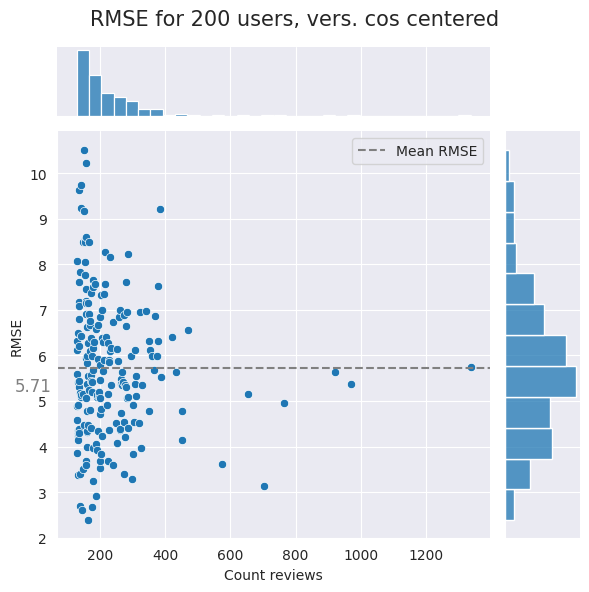

In [16]:
# we plot the RMSE distribution for cos

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="RMSE", kind="scatter")
plot.ax_joint.axhline(rmse_users["RMSE"].mean(), color="gray", linestyle="--", label="Mean RMSE")
plot.ax_joint.text(x=50, y=rmse_users["RMSE"].mean() - 0.5, s=f'{round(rmse_users["RMSE"].mean(), 2)}', color='gray', fontsize=12, ha='right')
plot.figure.suptitle(f'RMSE for {NB_USERS} users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()


In [17]:
# normalized RMSE 
rmse_users['Normalized RMSE'] = (rmse_users['RMSE'] - rmse_users['RMSE'].min()) / (rmse_users['RMSE'].max() - rmse_users['RMSE'].min())
rmse_users

,User id,RMSE,Count reviews,Normalized RMSE
86,1195,4.888653,128,0.308311
133,1919,5.582916,128,0.393795
154,2246,3.866552,129,0.182462
41,364,8.068840,129,0.699881
165,2282,4.589486,129,0.271476
...,...,...,...,...
33,201,3.134462,702,0.092322
11,91,4.945794,764,0.315347
8,83,5.643616,921,0.401268
0,1,5.374674,970,0.368154


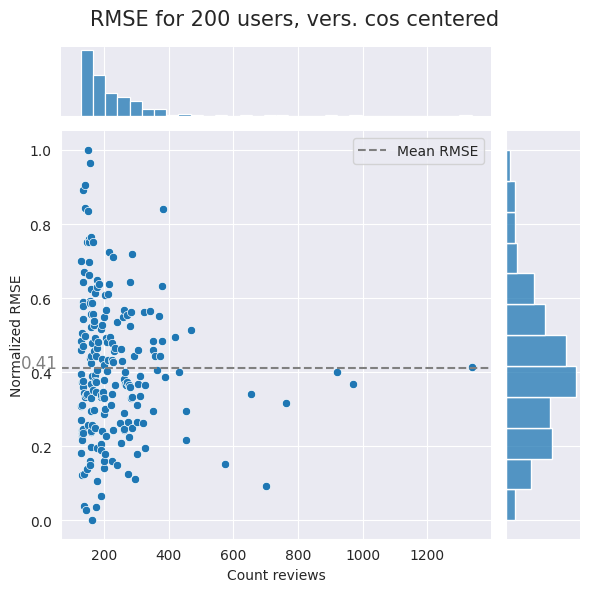

In [18]:
# we plot the RMSE normalized distribution

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="Normalized RMSE", kind="scatter")
plot.ax_joint.axhline(rmse_users["Normalized RMSE"].mean(), color="gray", linestyle="--", label="Mean RMSE")
plot.ax_joint.text(x=0, y=rmse_users["Normalized RMSE"].mean(), s=f'{round(rmse_users["Normalized RMSE"].mean(), 2)}', color='gray', fontsize=12, ha='center')
plot.figure.suptitle(f'RMSE for {NB_USERS} users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()

#### **MAE**

In [22]:
result = np.load("rmse_data/mae_centered_200_cos.npy")

In [19]:
# calculate mae DO NOT RUN CELL
vect_mae = np.vectorize(calc_MAE_cos, excluded=['matrix_ratings', 'mask_ratings', 'similarity_matrix'])
result = vect_mae(users, matrix_ratings=matrix_ratings, mask_ratings=mask_ratings, similarity_matrix=similarity_matrix)
np.save(f"rmse_data/mae_centered_{NB_USERS}_cos.npy", result)

In [23]:
# users_table_assoc[users] = true id of users
# we associate each users with their MAE and count reviews
rmse_users = pd.DataFrame(zip(users_table_assoc[users], result), columns=["User id", "MAE"]).merge(users_count, on ="User id")
rmse_users.columns = ["User id", "MAE", "Count reviews"]
rmse_users.sort_values(by="Count reviews", inplace=True)
# normalized MAE 
rmse_users['Normalized MAE'] = (rmse_users['MAE'] - rmse_users['MAE'].min()) / (rmse_users['MAE'].max() - rmse_users['MAE'].min())
rmse_users

,User id,MAE,Count reviews,Normalized MAE
86,1195,2.284787,128,0.664547
133,1919,1.746003,128,0.395488
154,2246,1.822462,129,0.433670
41,364,1.785141,129,0.415033
165,2282,1.947359,129,0.496041
...,...,...,...,...
33,201,1.679578,702,0.362316
11,91,1.611632,764,0.328386
8,83,1.906908,921,0.475841
0,1,1.851366,970,0.448104


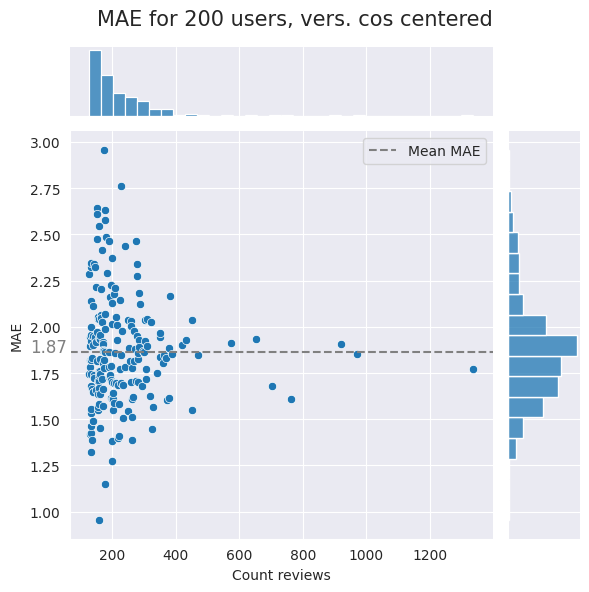

In [25]:
# we plot the MAE distribution

sns.set_style("darkgrid")
plot = sns.jointplot(data=rmse_users, x="Count reviews", y="MAE", kind="scatter")
plot.ax_joint.axhline(rmse_users["MAE"].mean(), color="gray", linestyle="--", label="Mean MAE")
plot.ax_joint.text(x=0, y=rmse_users["MAE"].mean(), s=f'{round(rmse_users["MAE"].mean(), 2)}', color='gray', fontsize=12, ha='center')
plot.figure.suptitle(f'MAE for {NB_USERS} users, vers. cos centered', fontsize=15)
plot.figure.tight_layout()
plot.ax_joint.legend()

##### Remarks
##### The MAE and RMSE were computed on different predicted games for the same users, aka need to get the predicted ratings and compute separately errors to see the differences, not all in one function